# Problem 1.1.1

In [1]:
import xml.etree.ElementTree as ET
import numpy as np

# setup
fp = "data/VOCdevkit/VOC2012/Annotations/2007_000027.xml"

def parse_file(fp):    
    # extract xml tree
    tree = ET.parse(fp)
    root = tree.getroot()

    # identify objects
    # extract boundary box data
    output = []
    for obj in root.findall("./object"):
        name = obj.find("name").text
        box = obj.find("bndbox")
        x = int(box.find("xmin").text)
        xmax = int(box.find("xmax").text)
        y = int(box.find("ymin").text)
        ymax = int(box.find("ymax").text)
        
        w = xmax - x
        h = ymax - y
        
        coords = [name, x, y, w, h]
        output.append(coords)

    # put in numpy array format 
    output = np.array(output)
    
    return(output)

# Problem 1.1.2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

xml_path = "data/VOCdevkit/VOC2012/Annotations/2007_000027.xml"
img_path = "data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg"

def show_image(img_path, xml_path):
    # load image
    # load xml file
    img = Image.open(img_path)
    bndbox = parse_file(xml_path)
    
    # make figure
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # make boxes
    for obj in bndbox:
        box = patches.Rectangle((int(obj[1]), int(obj[2])), int(obj[3]), int(obj[4]), 
                                linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(box)


# Problem 1.3

# Problem 2

In [59]:
from imagecorruptions import corrupt, get_corruption_names
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from time import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

# setup
corr_names = get_corruption_names()
folder_path = "data/VOCdevkit/VOC2012/JPEGImages/"

img_paths = [os.path.join(folder_path, img_path) for img_path in os.listdir(folder_path)]
random.shuffle(img_paths)
partition = int(0.8 * len(img_paths))
train_paths = img_paths[:partition]
val_paths = img_paths[partition:]

# generate corrupted datasets
def corrupt_set(img_paths):
    start = time()
    imgs_final = []
    for img_path in img_paths:
        # load image
        # resize image
        img = np.array(Image.open(img_path))
        img = cv2.resize(img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)

        # generate corruptions
        # add to larger dataset
        #for corr_name in corr_names:
        for sev in range(1,6):
            img_noised = corrupt(img, corruption_name="gaussian_noise", severity=sev)
            img_pair = np.stack([img_noised, img], axis=3)
            imgs_final.append(img_pair)
    print(time() - start)
    return(imgs_final)

# train_final = corrupt_set(train_paths)
# val_final = corrupt_set(val_paths)

# save dataset
# np.save("train_imgs.npy", train_final)
# np.save("val_imgs.npy", val_final)

In [124]:
# define image data class

class ImgData:
    def __init__(self, fp):
        # load dataset
        # reshape dataset
        data = np.load(fp).transpose(0,3,1,2,4).astype(np.float32)
        
        # split into corrupted, original images
        # convert to pytorch tensors
        self.corrupted = torch.from_numpy(data[:,:,:,:,0])
        self.orig = torch.from_numpy(data[:,:,:,:,1])
        
    def __len__(self):
        return len(self.corrupted)

    def __getitem__(self, rownum):
        corrupted = self.corrupted[rownum, :, :, :]
        orig = self.orig[rownum, :, :, :]
        return corrupted, orig
    

In [117]:
# define autoencoder model class

class CorruptioNet(nn.Module):
    def __init__(self):
        super(CorruptioNet, self).__init__()
        
        #self.Encoder = nn.Sequential(
        #    nn.Conv2d(3, 16, 3, stride=3, padding=1),
        #    nn.ReLU(True),
        #    #nn.MaxPool2d(2, stride=2),
        #    #nn.Conv2d(16, 8, 3, stride=2, padding=1),
        #    #nn.ReLU(True),
        #    #nn.MaxPool2d(2, stride=1)
        #)
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def Encoder(self, x):
        l1 = nn.Conv2d(3, 16, 3, stride=3, padding=1)
        l2 = nn.ReLU(True)
        print(x.dtype)
        img_proc = l1(x.byte())
        print(img_proc.dtype)
        img_proc = l2(img_proc)
        print(img_proc.dtype)
        return img_proc

    def forward(self, x):
        print(type(x))
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [6]:
# define training function

def train_model(model, data, epochs):
    # define loss function
    # set optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # set up data loader
    train_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=32)
    
    # run training loop
    losses = []
    for epoch in range(epochs):
        train_loss = 0
        for batch_id, (corrupted, orig) in enumerate(train_loader):
            optimizer.zero_grad()
            out_image = model(corrupted)
            loss = criterion(orig, out_image)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        losses.append([epoch, batch_id, train_loss])

    return model, losses

In [ ]:
start = time()
# train = ImgData("train_imgs.npy")
val = ImgData("val_imgs.npy")
print(time() - start)

In [ ]:
start = time()
model = CorruptioNet()
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=2)
id, (img_noised, img) = next(enumerate(val_loader))
model.Encoder(img_noised)
# trained_model, losses = train_model(model, val, 1)
print(time() - start)

In [100]:
print(type(img_noised))
print(img_noised.shape)
print(img_noised.dtype)

<class 'torch.Tensor'>
torch.Size([2, 3, 500, 500])
torch.uint8


In [ ]:
model = CorruptioNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=32)
epochs=1

# run training loop
losses = []
for epoch in range(epochs):
    train_loss = 0
    for batch_id, (corrupted, orig) in enumerate(train_loader):
        optimizer.zero_grad()
        out_image = model(corrupted)
        loss = criterion(orig, out_image)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    losses.append([epoch, batch_id, train_loss])

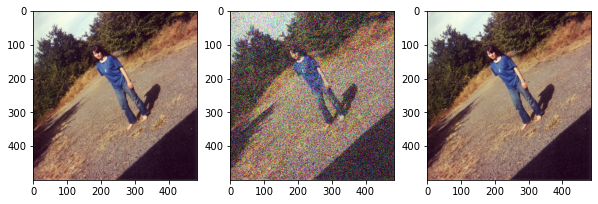

In [62]:
img_path = "data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg"
img = Image.open(img_path)
corr_name = "gaussian_noise"
sev = 5
img_noised = corrupt(np.array(img), corruption_name=corr_name, severity=sev)

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(img_noised)
ax[2].imshow(img)